# Swapping Saliency Map Generation Techniques With XAITK

This notebook contains a working example to demonstrate the API for visual saliency map generation for image black-box classifiers. This example will follow an application-like use case where we define a functionally rigid process that transforms an input image into a number of saliency heatmaps based on our black-box classifier's output, visualizing the heatmaps over the input image.

To showcase how easy it is to change which of our API implementations is used in the application without impacting the application's successful execution, we will define an application that takes an image, a black-box classifier, and a saliency map generator. This will require us to define a black-box classification model for which to introspect the saliency.

## Swappable Implementations

The xaitk-saliency package provides a relatively high-level API interface for visual saliency map generation. The `GenerateImageClassifierBlackboxSaliency` interface defines the following input requirements:

- a reference image
- a black-box classifier that performs inference over images

Over the course of this notebook, we will use different implementations of `GenerateImageClassifierBlackboxSaliency` to generate saliency maps. Since these all implement the same parent `abstract` class, they effectively all promise to abide by the API it defines. Thus, we should be able to use them all interchangeably, at least at the functional level. Their implementations may of course produce different results, as is the point of having varying implementations, but the types and form of the inputs and outputs should be the same.

The implementations here use perturbation-occlusion sub-pipelines as shown in this diagram.

![Perturbation-Occlusion Pipeline](figures/perturb_occlude_diagram.svg)


To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XAITK/xaitk-saliency/blob/master/docs/examples/SwappableImplementations.ipynb)

Note for Colab users: after setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the README for more info).

## The Test Image

We will test the implementations on the following image. We know that this image contains the ImageNet classes of "boxer" and "tiger cat".

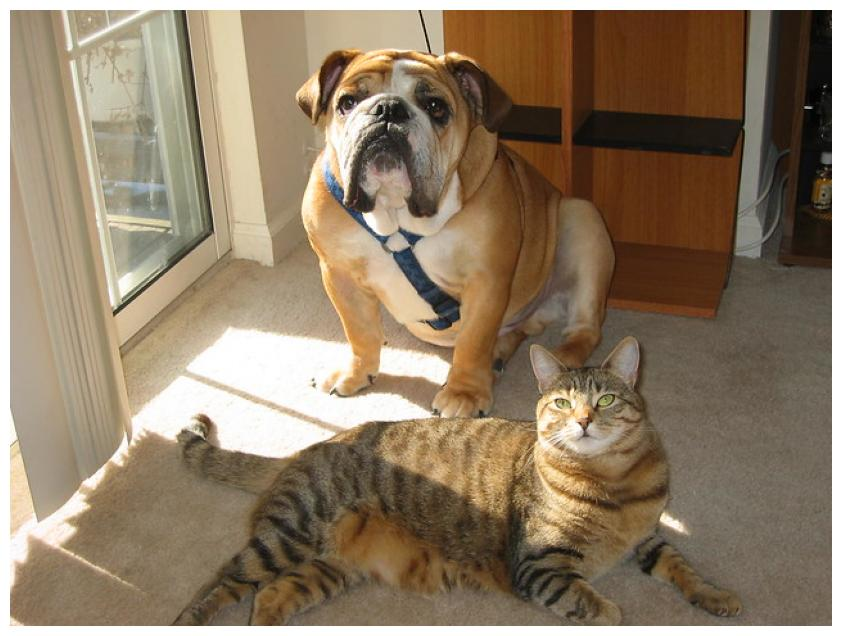

In [1]:
import os
import urllib.request
from collections.abc import Iterable, Sequence
from typing import Any

import matplotlib.pyplot as plt
import PIL.Image
from typing_extensions import override

# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"


os.makedirs("data", exist_ok=True)
test_image_filename = "data/catdog.jpg"
urllib.request.urlretrieve("https://farm1.staticflickr.com/74/202734059_fcce636dcd_z.jpg", test_image_filename)
plt.figure(figsize=(12, 8))
plt.axis("off")
_ = plt.imshow(PIL.Image.open(test_image_filename))

## Black-Box Classifier

In this example, we will use a basic PyTorch-based, pretrained ResNet18 model and use its softmax output as classification confidences. Since this model normally outputs 1000 classes, we will, for simplicity of example, constrain the output to the two classes that are relevant for our test image. This will be wrapped up in an implementation of the `ClassifyImage` interface for input to our "application." This sub-classing standardizes classifier operation with our API to support the varying ways classification is performed across toolkits and applications.

In [2]:
# Set up our "black box" classifier using PyTorch and it's ImageNet pretrained ResNet18.
# We will constrain the output of our classifier here to the two classes that are relevant
# to our test image for the purposes of this example.
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from smqtk_classifier import ClassifyImage

CUDA_AVAILABLE = torch.cuda.is_available()


model = models.resnet18(pretrained=True)
model = model.eval()
if CUDA_AVAILABLE:
    model = model.cuda()

# These are some simple helper functions to perform prediction with this model
model_input_size = (224, 224)
model_mean = [0.485, 0.456, 0.406]
model_loader = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(model_input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=model_mean, std=[0.229, 0.224, 0.225]),
    ],
)


# Grabbing the class labels associated with this model.
classes_file = "data/imagenet_classes.txt"
if not os.path.isfile(classes_file):
    !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O {classes_file}

with open(classes_file) as f:
    categories = [s.strip() for s in f.readlines()]


# For this test, we will use an image with both a cat and a dog in it.
# Let's only consider the saliency of two class predictions.
sal_class_labels = ["boxer", "tiger cat"]
sal_class_idxs = [categories.index(lbl) for lbl in sal_class_labels]


class TorchResnet18(ClassifyImage):
    """Blackbox model to output the two focus classes."""

    @override
    def get_labels(self) -> Sequence[str]:
        """Return class labels"""
        return sal_class_labels

    @override
    @torch.no_grad()
    def classify_images(self, image_iter: Iterable[np.ndarray]) -> dict[str, Any]:
        """Input may either be an NDaray, or some arbitrary iterable of NDarray images."""

        for img in image_iter:
            image_tensor = model_loader(img).unsqueeze(0)
            if CUDA_AVAILABLE:
                image_tensor = image_tensor.cuda()
            feature_vec = model(image_tensor)
            # Converting feature extractor output to probabilities.
            class_conf = torch.nn.functional.softmax(feature_vec, dim=1).cpu().detach().numpy().squeeze()
            # Only return the confidences for the focus classes
            yield dict(zip(sal_class_labels, class_conf[sal_class_idxs]))

    @override
    def get_config(self) -> dict[str, Any]:
        """Required by a parent class."""
        return {}


blackbox_classifier = TorchResnet18()

blackbox_fill = np.uint8(np.asarray(model_mean) * 255)

/home/local/KHQ/stephen.crowell/.cache/pypoetry/virtualenvs/xaitk-saliency-eX2AjeRl-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/local/KHQ/stephen.crowell/.cache/pypoetry/virtualenvs/xaitk-saliency-eX2AjeRl-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## The "Application"

The function below is an example "application" that takes an image, a black-box classifier, and a saliency map generator to showcase how simple it is to swap between XAITK's saliency map generators. For each saliency map generated, the "application" will print the range of values in the saliency map, visualize the positive saliency values overlaid the original image, and visualize the negative saliency values overlaid the original image.

In [3]:
import matplotlib.pyplot as plt
import PIL.Image

from xaitk_saliency import GenerateImageClassifierBlackboxSaliency


def app(
    image_filepath: str,
    # Assuming outputs `nClass` length arrays.
    blackbox_classify: ClassifyImage,
    gen_bb_sal: GenerateImageClassifierBlackboxSaliency,
) -> None:
    """Helper function to generate and visualize saliency maps"""
    # Load the image
    ref_image = np.asarray(PIL.Image.open(image_filepath))
    sal_maps = gen_bb_sal(ref_image, blackbox_classify)
    print(f"Saliency maps: {sal_maps.shape}")
    visualize_saliency(ref_image, sal_maps)


def visualize_saliency(ref_image: np.ndarray, sal_maps: np.ndarray) -> None:
    """Visualize the saliency heat-maps"""
    sub_plot_ind = len(sal_maps) + 1
    plt.figure(figsize=(12, 6))
    plt.subplot(2, sub_plot_ind, 1)
    plt.imshow(ref_image)
    plt.axis("off")
    plt.title("Test Image")

    # Some magic numbers here to get colorbar to be roughly the same height
    # as the plotted image.
    colorbar_kwargs = {
        "fraction": 0.046 * (ref_image.shape[0] / ref_image.shape[1]),
        "pad": 0.04,
    }

    for i, class_sal_map in enumerate(sal_maps):
        print(f"Class {i} saliency map range: [{class_sal_map.min()}, {class_sal_map.max()}]")

        # Positive half saliency
        plt.subplot(2, sub_plot_ind, 2 + i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(np.clip(class_sal_map, 0, 1), cmap="jet", alpha=0.3)
        plt.clim(0, 1)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Class #{i + 1} Pos Saliency")
        plt.axis("off")

        # Negative half saliency
        plt.subplot(2, sub_plot_ind, sub_plot_ind + 2 + i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(np.clip(class_sal_map, -1, 0), cmap="jet_r", alpha=0.3)
        plt.clim(-1, 0)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Class #{i + 1} Neg Saliency")
        plt.axis("off")

## Sliding Window Method

Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-1.0, 0.6748984456062317]
Class 1 saliency map range: [-1.0, 0.9845045804977417]


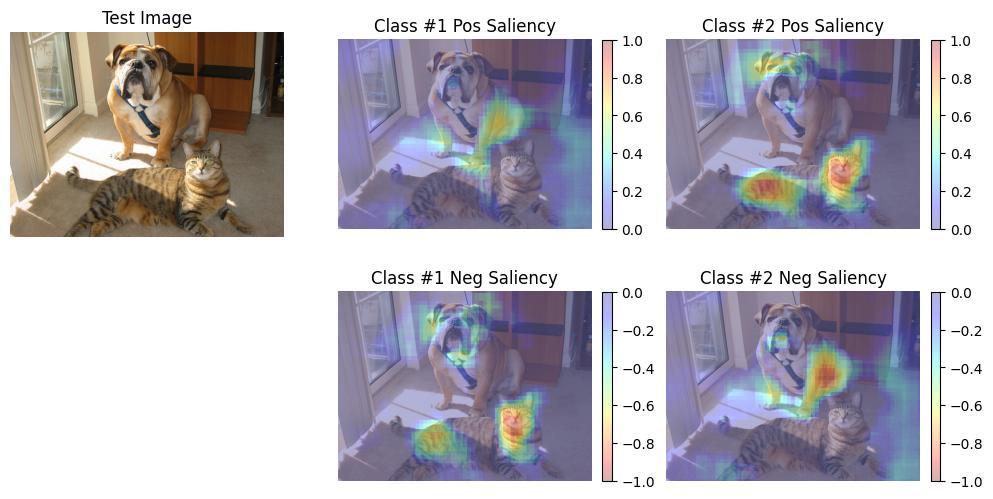

In [4]:
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack

gen_slidingwindow = SlidingWindowStack((50, 50), (20, 20), threads=4)

# This generator implementation has a slot for filling background occlusion,
# which our choice of classifier should ideally take for best operation.
gen_slidingwindow.fill = blackbox_fill

app(
    test_image_filename,
    blackbox_classifier,
    gen_slidingwindow,
)

## RISE

Saliency maps: (2, 480, 640)
Class 0 saliency map range: [0.4040015637874603, 1.0]
Class 1 saliency map range: [0.6812227368354797, 1.0]


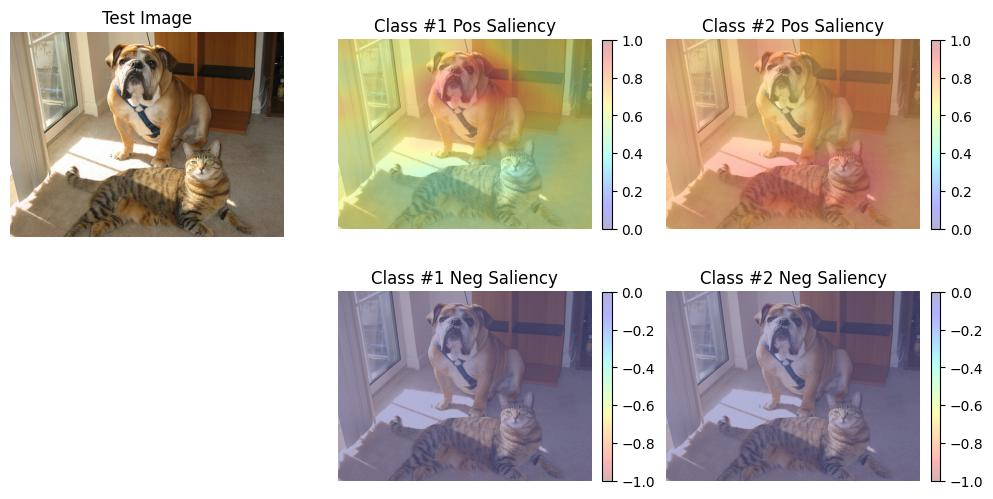

In [5]:
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.rise import RISEStack

gen_rise = RISEStack(1000, 8, 0.5, seed=0, threads=4, debiased=False)

# This generator implementation has a slot for filling background occlusion,
# which our choice of classifier should ideally take for best operation.
gen_rise.fill = blackbox_fill

app(test_image_filename, blackbox_classifier, gen_rise)

## RISE with Debiasing

Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-0.5117952823638916, 1.0]
Class 1 saliency map range: [-0.4980420768260956, 1.0]


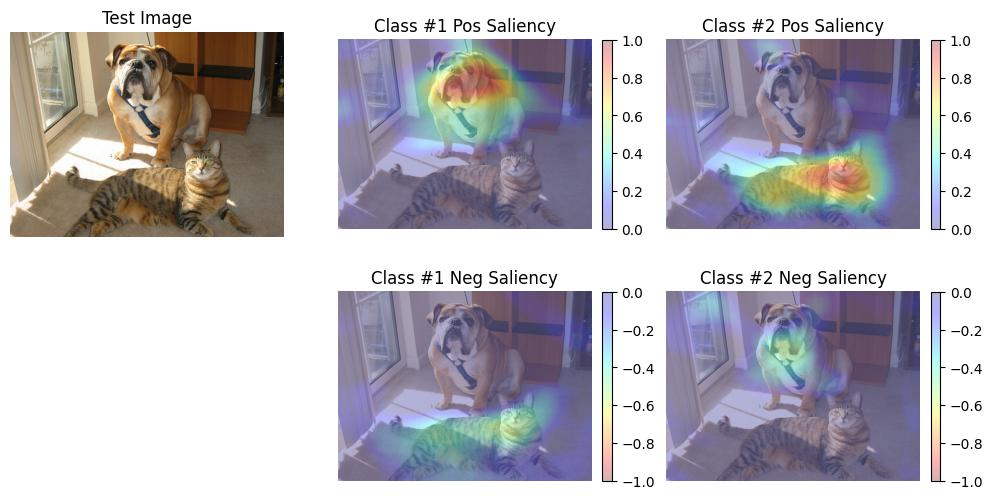

In [6]:
gen_rise_debiased = RISEStack(1000, 8, 0.5, seed=0, threads=4, debiased=True)

# This generator implementation has a slot for filling background occlusion,
# which our choice of classifier should ideally take for best operation.
gen_rise_debiased.fill = blackbox_fill

app(
    test_image_filename,
    blackbox_classifier,
    gen_rise_debiased,
)